# Umap gallery of Cutouts

In [1]:
### used to set the interpreter searching path
import sys
target_path = '/home/jovyan/ulmo/'
sys.path.append(target_path)

In [2]:
%matplotlib inline

from importlib import reload
import os
import numpy as np
from pkg_resources import resource_filename

import pandas

import h5py
import seaborn as sns
import pandas as pd
from ulmo import plotting
from ulmo.ssl.train_util import modis_loader, set_model
from ulmo.ssl.train_util import Params, option_preprocess
from ulmo.ssl import latents_extraction
from ulmo.plotting import load_palette

import torch

from matplotlib import pyplot as plt
from tqdm import trange

In [3]:
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
llc_curl_path = "/home/jovyan/ulmo/ulmo/runs/SSL/llc_ssl_kin/experiments/llc_modis_2012_curl_latents/"
llc_curl_reduced_latents = os.path.join(llc_curl_path, os.listdir(llc_curl_path)[1])

In [5]:
llc_curl_reduced_latents = pd.read_feather(llc_curl_reduced_latents).values

In [6]:
llc_curl_path = "/home/jovyan/ulmo/ulmo/runs/SSL/llc_ssl_kin/experiments/llc_modis_2012_curl_latents/"
llc_curl_latents_file = os.path.join(llc_curl_path, os.listdir(llc_curl_path)[0])

In [7]:
with h5py.File(llc_curl_latents_file, 'r') as f:
    llc_curl_latents = f['valid'][:]

In [8]:
llc_curl_data_path = "/home/jovyan/ulmo/ulmo/runs/SSL/experiments/datasets/llc_kin_dataset/LLC_modis2012_curl_preproc.h5"

In [9]:
with h5py.File(llc_curl_data_path, 'r') as f:
    print(f.keys())
    llc_curl_data = f['valid'][:]

<KeysViewHDF5 ['valid', 'valid_metadata']>


In [10]:
llc_curl_latents.shape

(635295, 256)

In [11]:
llc_curl_reduced_latents.shape

(635295, 2)

In [12]:
reduced_latent_x = np.median(llc_curl_reduced_latents[:, 0])

In [13]:
reduced_x_index_lower = np.argwhere(reduced_latent_x - 0.1 < llc_curl_reduced_latents[:, 0])
reduced_x_index_upper = np.argwhere(reduced_latent_x + 0.1 > llc_curl_reduced_latents[:, 0])

In [14]:
reduced_x_index = set(reduced_x_index_lower.squeeze(axis=1)) & set(reduced_x_index_upper.squeeze(axis=1))

In [15]:
reduced_x_index = np.array(list(reduced_x_index))

In [16]:
reduced_latent_y = np.sort(llc_curl_reduced_latents[reduced_x_index, 1])[reduced_x_index.shape[0] // 2]

In [17]:
reduced_y_index = np.argwhere(llc_curl_reduced_latents == reduced_latent_y)

In [18]:
center_index = set(reduced_x_index) & set(reduced_y_index[0])

In [19]:
reduced_latent_center = llc_curl_reduced_latents[list(center_index)[0]]

In [20]:
sim_matrix = cosine_similarity(np.array([llc_curl_latents[list(center_index)[0]]]), llc_curl_latents)

## Function used to show the cutouts gallery by picking out the maximum similarity image from each group

In [24]:
def set_fontsize(ax, fsz):
    """
    Set the fontsize throughout an Axis
    Args:
        ax (Matplotlib Axis):
        fsz (float): Font size
    Returns:
    """
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fsz)

In [29]:
def umap_gallery_max(main_tbl, sim_array, data_array, outfile=None, point_sz_scl=1., width=800, 
                     height=800, vmnx=(-1000.,None), dxdy=(0.3, 0.3),
                     Nx=20, debug=None):
    """Generate a UMAP plot and overplot a gallery
    of cutouts
    Args:
        main_tbl (pandas.DataFrame): Table of quantities.
        sim_array (np.array): Sim array.
        data_array (np.array): Cutouts images.
        outfile (str, optional): Outfile for the figure. Defaults to None.
        point_sz_scl (float, optional): Point size for UMAP points. Defaults to 1..
        width (int, optional): Width of the figure. Defaults to 800.
        height (int, optional): Height of the figure. Defaults to 800.
        vmnx (tuple, optional): Color bar vmin,vmax. Defaults to (-1000.,None).
        dxdy (tuple, optional): Amount to pad the xlim, ylim by. Defaults to (0.3, 0.3).
        Nx (int, optional): Number of cutout images in x to show. Defaults to 20.
        debug (bool, optional): Debug? Defaults to None.
    Returns:
        matplotlib.plt.Axes: Axis
    """

    _, cm = load_palette()

    num_samples = len(main_tbl)
    point_size = point_sz_scl / np.sqrt(num_samples)
    dpi = 100
    
    vmin, vmax = np.min(sim_array), np.max(sim_array)
    # New plot
    plt.figure(figsize=(width//dpi, height//dpi))
    ax = plt.gca()
    img = ax.scatter(main_tbl.U0, main_tbl.U1,
            s=point_size, cmap='jet', c=sim_array, vmin=vmin, vmax=vmax)
    cb = plt.colorbar(img, pad=0.)
    cb.set_label('Similarity', fontsize=20.)
    #
    ax.set_xlabel(r'$U_0$')
    ax.set_ylabel(r'$U_1$')

    # Set boundaries
    xmin, xmax = main_tbl.U0.min()-dxdy[0], main_tbl.U0.max()+dxdy[0]
    ymin, ymax = main_tbl.U1.min()-dxdy[1], main_tbl.U1.max()+dxdy[1]
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # ###################
    # Gallery time

    # Grid
    xval = np.linspace(xmin, xmax, num=Nx)
    dxv = xval[1]-xval[0]
    yval = np.arange(ymin, ymax+dxv, step=dxv)

    # Ugly for loop
    pp_hf = None
    ndone = 0
    if debug:
        nmax = 100
    else:
        nmax = 1000000000
    for x in xval[:-1]:
        for y in yval[:-1]:
            pts = np.where((main_tbl.U0 >= x) & (main_tbl.U0 < x+dxv) & (
                main_tbl.U1 >= y) & (main_tbl.U1 < y+dxv))[0]
            if len(pts) == 0:
                continue

            # Pick a random one
            index_max = np.argmax(sim_array[pts])
            #ichoice = np.random.choice(len(pts), size=1)
            #idx = int(pts[ichoice])
            cutout_img = data_array[pts[index_max]]

            # Image
            axins = ax.inset_axes(
                    [x, y, 0.9*dxv, 0.9*dxv], 
                    transform=ax.transData)
            _ = sns.heatmap(np.flipud(cutout_img[0]), xticklabels=[], 
                     yticklabels=[], cmap=cm, cbar=False,
                     ax=axins)
            ndone += 1
            #print(f'ndone= {ndone}, LL={cutout.LL}')
            if ndone > nmax:
                break
        if ndone > nmax:
            break

    set_fontsize(ax, 15.)
    ax.set_aspect('equal', 'datalim')
    # Finish
    if outfile is not None:
        plt.savefig(outfile, dpi=300)
        print(f"Wrote: {outfile}")

    return ax

In [30]:
valid_tbl = {}
valid_tbl['U0'] = llc_curl_reduced_latents[:, 0]
valid_tbl['U1'] = llc_curl_reduced_latents[:, 1]
valid_tbl = pd.DataFrame(valid_tbl)

Wrote: ./umap_cutouts_gallery_max_epoch_20.png


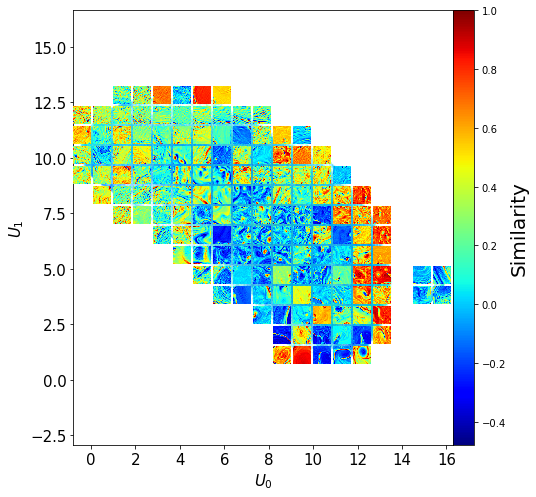

In [31]:
sim_gallery_file = './umap_cutouts_gallery_max_epoch_20.png'
ax = umap_gallery_max(valid_tbl, sim_matrix.squeeze(axis=0), llc_curl_data, sim_gallery_file)